In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import researchpy as rp
from scipy import stats

from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.stats.multicomp
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.imputation import mice
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn_pandas import CategoricalImputer

import scipy

from PIL import Image, TiffImagePlugin
from io import BytesIO

import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode

import pingouin as pg
from pingouin import ancova

%matplotlib inline
warnings.filterwarnings('ignore')
tls.set_credentials_file(username='ttuti', api_key='jWVEJiRSCUfABsfFh5Dr')

sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,9)})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})
TiffImagePlugin.WRITE_LIBTIFF = True

### LIFE Pre Analysis 

In [2]:
life_users = pd.read_csv('D:/DPhil - University of Oxford/Data/users.csv')
life_users.tail()

,Age,Cadre,Clinician,ConsentGiven,Country,ETAT,Email,Experience,Institution,Level,Region,Session,StudyGroup,User,No_Session,No_Session_Complete
585,NaN,NaN,True,False,ke,False,Empty,NaN,NaN,NaN,NaN,2019-04-04 19:13:36,1,E68A8D94D4E88C1486651F2F027C3F33,1.0,0.0
586,NaN,NaN,True,False,ke,False,Empty,NaN,NaN,NaN,NaN,2019-06-10 17:44:44,1,ED263A1D7C406770F2120C8BCCE971A3,8.0,5.0
587,NaN,NaN,True,False,ke,False,Empty,NaN,NaN,NaN,NaN,2019-07-27 17:18:50,1,EEA52D2A8CA5C41D645A370E9265D001,2.0,1.0
588,NaN,NaN,True,False,ke,False,Empty,NaN,NaN,NaN,NaN,2019-03-27 07:56:41,1,F0D90A1EA014FEA1272041376B3FF2B3,3.0,1.0
589,NaN,NaN,True,False,ke,False,Empty,NaN,NaN,NaN,NaN,2019-04-13 05:37:12,1,F39F33872AD377772D51BB33B236DED4,2.0,0.0


In [3]:
norm_gain = pd.read_csv('D:/DPhil - University of Oxford/Data/Norm.csv')
norm_gain.head()

,User,Session,Question,Try,Cycle,Time,Correct,Feedback,Quiz_Attempted,Session_Complete,Complete_Plays
0,0124251270AF600B4D7B52D47E6EF095,2019-04-11 08:52:18,1,1,1,15.688,1,0,10,1,2
1,0124251270AF600B4D7B52D47E6EF095,2019-04-11 08:52:18,2,1,1,31.204,0,1,10,1,2
2,0124251270AF600B4D7B52D47E6EF095,2019-04-11 08:52:18,3,1,1,19.141,1,1,10,1,2
3,0124251270AF600B4D7B52D47E6EF095,2019-04-11 08:52:18,4,1,1,25.439,0,1,10,1,2
4,0124251270AF600B4D7B52D47E6EF095,2019-04-11 08:52:18,5,1,1,37.881,1,1,10,1,2


In [4]:
space_time_gain = norm_gain[['User','Session','Cycle']]
space_time_gain = space_time_gain.drop_duplicates(['User','Session','Cycle'])
space_time_gain = space_time_gain.pivot_table('Session',['User'],'Cycle',aggfunc='first')
space_time_gain = space_time_gain.reset_index()
space_time_gain.rename(columns={1:'Pre',2:'Post'}, inplace=True)
space_time_gain['Time_Between'] = np.nan

for index,row in space_time_gain.iterrows():
    pre,post = pd.to_datetime(row['Pre']),pd.to_datetime(row['Post'])   
    space_time_gain.loc[index,'Time_Between'] = np.ceil(((post - pre).total_seconds())/60)

space_time_gain = space_time_gain.drop(['Pre','Post'],axis=1)
space_time_gain.tail()

Cycle,User,Time_Between
242,FC7104BD372E47D96A882C9C91BBA6BE,15.0
243,FD0BEA59B3DE0F4E7C10E4692258ABAD,20.0
244,FE1BE6B0A9A43AB1A82921BBADEED898,50.0
245,FEAC53028EDFCBC25DD87F80F4C28089,14.0
246,FF6BC3D6D1571FA39533C28DC049C488,6762.0


In [5]:
pre_post_scores = norm_gain.groupby(['User','Cycle']).Correct.agg('sum')
pre_post_scores = pre_post_scores.to_frame()
pre_post_scores.reset_index(inplace=True)
pre_post_scores.Cycle = pre_post_scores.Cycle.astype(int)
pre_post_scores['Score'] = np.round(pre_post_scores.Correct/10,4)*100
pre_post_scores.tail()

,User,Cycle,Correct,Score
489,FE1BE6B0A9A43AB1A82921BBADEED898,2,9,90.0
490,FEAC53028EDFCBC25DD87F80F4C28089,1,2,20.0
491,FEAC53028EDFCBC25DD87F80F4C28089,2,9,90.0
492,FF6BC3D6D1571FA39533C28DC049C488,1,7,70.0
493,FF6BC3D6D1571FA39533C28DC049C488,2,8,80.0


In [6]:
norm_calc = pre_post_scores.pivot_table('Score',['User'],'Cycle')
norm_calc = norm_calc.reset_index()
norm_calc.rename(columns={1:'Pre',2:'Post'}, inplace=True)
norm_calc.tail()

Cycle,User,Pre,Post
242,FC7104BD372E47D96A882C9C91BBA6BE,60.0,80.0
243,FD0BEA59B3DE0F4E7C10E4692258ABAD,60.0,90.0
244,FE1BE6B0A9A43AB1A82921BBADEED898,30.0,90.0
245,FEAC53028EDFCBC25DD87F80F4C28089,20.0,90.0
246,FF6BC3D6D1571FA39533C28DC049C488,70.0,80.0


In [7]:
print("Base conversion rate: "+str(round(np.mean(norm_calc.Pre),2)))

Base conversion rate: 53.81


In [8]:
combine_features = pd.merge(norm_calc,life_users,how='left',on=['User']) 
combine_features = pd.merge(combine_features,space_time_gain,how='left',on=['User']) 
combine_features.No_Session_Complete = combine_features.No_Session_Complete - 2.0

#Fix user error
combine_features.loc[combine_features.User=='13D5916C4982A226882E83859CE5555C',['Age']]=float(combine_features.Age[combine_features.User=='13D5916C4982A226882E83859CE5555C'].astype(str).tolist()[0][0:2])
#combine_features.loc[combine_features.User=='44236A7F7DC7F795BA38A98B8D98527B',['Age']]=float(combine_features.Age[combine_features.User=='44236A7F7DC7F795BA38A98B8D98527B'].astype(str).tolist()[0][0:2])

combine_features.tail()

,User,Pre,Post,Age,Cadre,Clinician,ConsentGiven,Country,ETAT,Email,Experience,Institution,Level,Region,Session,StudyGroup,No_Session,No_Session_Complete,Time_Between
242,FC7104BD372E47D96A882C9C91BBA6BE,60.0,80.0,NaN,NaN,True,True,ke,False,Empty,NaN,NaN,NaN,Sub-Saharan Africa,2019-07-09 14:21:55,1,8.0,2.0,15.0
243,FD0BEA59B3DE0F4E7C10E4692258ABAD,60.0,90.0,25.0,Doctor,True,True,ke,True,johnnjama42@gmail.com,2.0,The University of Nairobi,Student,Sub-Saharan Africa,2019-04-02 12:38:50,1,4.0,2.0,20.0
244,FE1BE6B0A9A43AB1A82921BBADEED898,30.0,90.0,27.0,Nurse,True,True,ke,True,Empty,4.0,KMTC Nairobi campus,Student,Sub-Saharan Africa,2019-03-26 21:11:00,1,6.0,3.0,50.0
245,FEAC53028EDFCBC25DD87F80F4C28089,20.0,90.0,NaN,NaN,True,False,my,False,Empty,NaN,NaN,NaN,South-eastern Asia,2019-06-16 21:39:06,1,3.0,1.0,14.0
246,FF6BC3D6D1571FA39533C28DC049C488,70.0,80.0,30.0,Nurse,True,True,ke,False,Empty,3.0,amref,Student,Sub-Saharan Africa,2019-07-04 19:57:33,2,3.0,0.0,6762.0


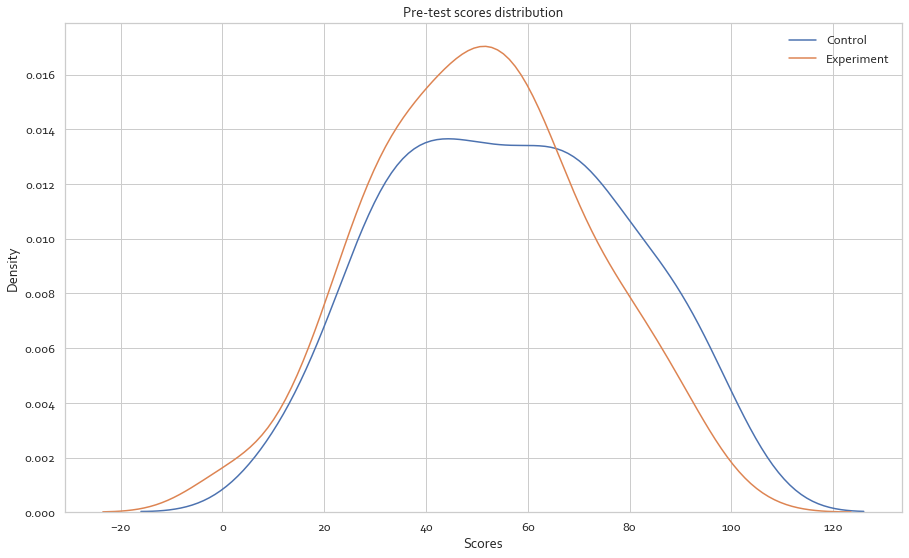

In [9]:
ax1 = sns.distplot(combine_features.Pre[combine_features.StudyGroup==1],hist=False, label='Control')  
ax2 = sns.distplot(combine_features.Pre[combine_features.StudyGroup==2],hist=False, label='Experiment') 

ax1.set(xlabel='Scores', ylabel='Density', title = "Pre-test scores distribution")
plt.show()

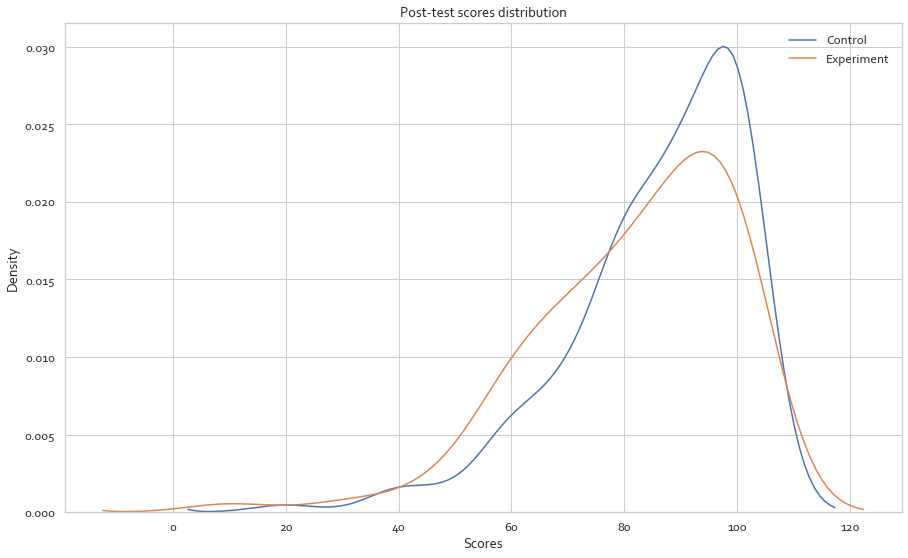

In [10]:
ax1 = sns.distplot(combine_features.Post[combine_features.StudyGroup==1],hist=False, label='Control')  
ax2 = sns.distplot(combine_features.Post[combine_features.StudyGroup==2],hist=False, label='Experiment') 

ax1.set(xlabel='Scores', ylabel='Density', title = "Post-test scores distribution")
plt.show()

In [11]:
%%latex


$$  c = \Bigg\{\begin{matrix}
    \frac{post-pre}{100-pre} & post > pre \\
    drop & post = pre = 100 = 0 \\
    0 & post = pre \\
    \frac{post-pre}{pre} & post < pre \\
  \end{matrix}  $$

<IPython.core.display.Latex object>

In [12]:
def calc_norm_gain(pre,post):
    if(post > pre):
        return ((post-pre)/(100-pre))
    elif(pre==post):
        return (0)
    elif(post < pre):
        return((post-pre)/pre)
    else:
        return None
    
for index, row in combine_features.iterrows():
    user,pre,post = row['User'],row['Pre'],row['Post']   
    combine_features.loc[index,'Gain'] = calc_norm_gain(pre,post)

combine_features['ETAT_trained'] = np.nan
combine_features.loc[combine_features.ETAT,['ETAT_trained']] = 1
combine_features.loc[~combine_features.ETAT,['ETAT_trained']] = 0
combine_features.ETAT_trained = combine_features.ETAT_trained.astype(int)
srl_gain_users = combine_features[['User','Gain','No_Session','No_Session_Complete']]
srl_gain_users.to_csv('D:\DPhil - University of Oxford\Reports\SRL\srl_gain.csv',index=False)
combine_features.tail()

,User,Pre,Post,Age,Cadre,Clinician,ConsentGiven,Country,ETAT,Email,...,Institution,Level,Region,Session,StudyGroup,No_Session,No_Session_Complete,Time_Between,Gain,ETAT_trained
242,FC7104BD372E47D96A882C9C91BBA6BE,60.0,80.0,NaN,NaN,True,True,ke,False,Empty,...,NaN,NaN,Sub-Saharan Africa,2019-07-09 14:21:55,1,8.0,2.0,15.0,0.500000,0
243,FD0BEA59B3DE0F4E7C10E4692258ABAD,60.0,90.0,25.0,Doctor,True,True,ke,True,johnnjama42@gmail.com,...,The University of Nairobi,Student,Sub-Saharan Africa,2019-04-02 12:38:50,1,4.0,2.0,20.0,0.750000,1
244,FE1BE6B0A9A43AB1A82921BBADEED898,30.0,90.0,27.0,Nurse,True,True,ke,True,Empty,...,KMTC Nairobi campus,Student,Sub-Saharan Africa,2019-03-26 21:11:00,1,6.0,3.0,50.0,0.857143,1
245,FEAC53028EDFCBC25DD87F80F4C28089,20.0,90.0,NaN,NaN,True,False,my,False,Empty,...,NaN,NaN,South-eastern Asia,2019-06-16 21:39:06,1,3.0,1.0,14.0,0.875000,0
246,FF6BC3D6D1571FA39533C28DC049C488,70.0,80.0,30.0,Nurse,True,True,ke,False,Empty,...,amref,Student,Sub-Saharan Africa,2019-07-04 19:57:33,2,3.0,0.0,6762.0,0.333333,0


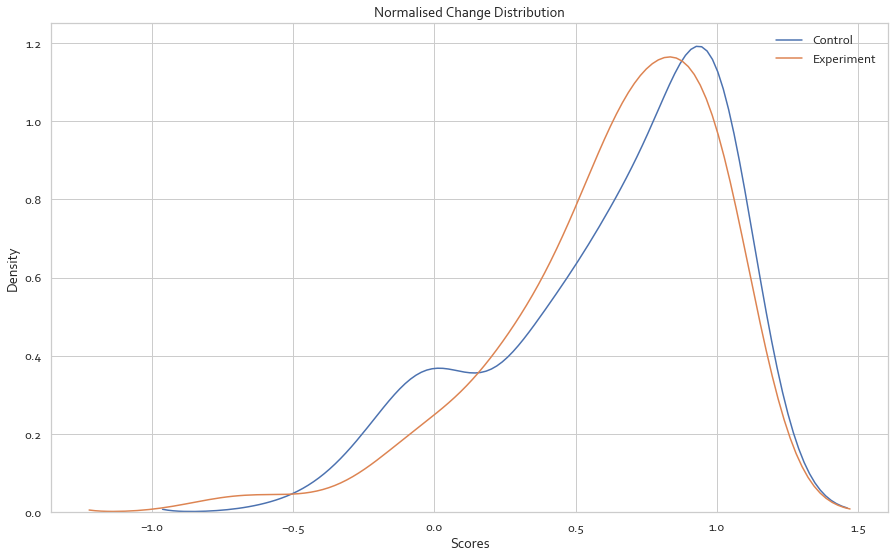

In [13]:
ax1 = sns.distplot(combine_features.Gain[combine_features.StudyGroup==1],hist=False, label='Control')  
ax2 = sns.distplot(combine_features.Gain[combine_features.StudyGroup==2],hist=False, label='Experiment') 

ax1.set(xlabel='Scores', ylabel='Density', title = "Normalised Change Distribution")
plt.show()

In [14]:
combine_features.ETAT_trained.value_counts()

1    137
0    110
Name: ETAT_trained, dtype: int64

In [15]:
x_ctrl=['Control']*len(combine_features.Gain[combine_features.StudyGroup==1])
y_ctrl=combine_features.Gain[combine_features.StudyGroup==1].tolist()
y_ctrl = np.round(y_ctrl,2)

x_exp=['Experiment']*len(combine_features.Gain[combine_features.StudyGroup==2])
y_exp=combine_features.Gain[combine_features.StudyGroup==2].tolist()
y_exp = np.round(y_exp,2)

control_group = go.Box(
    y=y_ctrl,
    x=x_ctrl,
    name = 'Control Group',
)
experiment_group = go.Box(
    y=y_exp,
    x=x_exp,
    name = 'Experiment Group',
)

layout = go.Layout(
    title='Normalised change in scores by study group',
    xaxis=dict(title='Study Groups'),
    yaxis=dict(title='Normalised change'),
    boxmode='group',
    font=dict(family='Corbel', size=18, color='#7f7f7f')
)

data = [control_group,experiment_group]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)  

PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, 'https://plotly.com/~ttuti/778/', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [ ]:
group_est_pre = combine_features.groupby(['StudyGroup']).Pre.agg({'N':'count','Mean':'mean','SD':'std'})
group_est_pre.reset_index(inplace=True)
group_est_pre.SD = np.round(group_est_pre.SD,2)
group_est_pre.Mean = np.round(group_est_pre.Mean,2)
study_group_series = group_est_pre.StudyGroup
group_est_pre = group_est_pre.drop(['StudyGroup'],axis=1)
group_est_pre.columns = pd.MultiIndex.from_product([['Pre-test'],group_est_pre.columns])

In [ ]:
group_est_post = combine_features.groupby(['StudyGroup']).Post.agg({'N':'count','Mean':'mean','SD':'std'})
group_est_post.reset_index(inplace=True)
group_est_post.SD = np.round(group_est_post.SD,2)
group_est_post.Mean = np.round(group_est_post.Mean,2)

In [ ]:
study_group_series=study_group_series.to_frame()
study_group_series.columns = pd.MultiIndex.from_product([[''],study_group_series.columns])
group_est_post = group_est_post.drop(['StudyGroup'],axis=1)
group_est_post.columns = pd.MultiIndex.from_product([['Post-test'],group_est_post.columns])
combined = pd.concat([study_group_series,group_est_pre,group_est_post],axis=1, sort=False)
combined

In [16]:
def cohend(d1, d2):
    d1 = np.divide(d1,100)
    d2 = np.divide(d2,100)    
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1) # calculate the variance of the samples 
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))# calculate the pooled standard deviation
    u1, u2 = np.mean(d1), np.mean(d2)    
    _,pvalue = stats.ttest_ind(d1, d2, equal_var=False) # calculate p-value
    return(np.round(((u1 - u2)/s),2),np.round(pvalue,3),s) # return the effect size, and p-value

def cohend_ci(effect, d1, d2):
    n1, n2 = len(d1), len(d2)
    V_d =((n1+n2)/(n1*n2))+(np.square(effect)/(2*(n1+n2)))
    se= np.sqrt(V_d)    
    CI = np.round(effect - (se*1.96),2) , np.round(effect + (se*1.96),2)
    return(CI)

def matched_d(d1, d2): # meta-analysis  (4.7 - 4.9)
    n1 = len(d1)
    d1 = np.divide(d1,100)
    d2 = np.divide(d2,100)  
    x_diff = np.mean(np.subtract(d2,d1))
    var_diff = np.var(np.subtract(d2,d1),ddof=1)
    _,pvalue = stats.ttest_rel(d1,d2)
    se_diff = stats.sem(np.subtract(d2,d1))
    CI = np.round(x_diff - (se_diff*1.96),2) , np.round(x_diff + (se_diff*1.96),2)    
    return(np.round(x_diff,2),CI,np.round(pvalue,3))
    
def hedgesg_ci(effect, n1, n2, s): #Meta-analysis 4.5
    SE_g = np.sqrt((np.square(s)/n1) + (np.square(s)/n2))
    CI = round(effect - (SE_g*1.96),3) , round(effect + (SE_g*1.96),3)
    Z_score = effect / SE_g
    pvalue = stats.norm.sf(abs(Z_score))*2 #twosided
    return(CI,round(pvalue,4))

def bias_correct(d1,d2): #Morris g (14)
    n1, n2 = len(d1),len(d2)
    Cpp=1-(3/((4*((2*n1)+(2*n2)-4))-1))
    return(Cpp)

def morris_g(d1,d2,d3,d4): #post_ctrl,pre_ctrl,post_exp,pre_exp, Morris g (12-14)
    n1, n2 = len(d1),len(d3)
    d1 = np.divide(d1,100)
    d2 = np.divide(d2,100)
    d3 = np.divide(d3,100)
    d4 = np.divide(d4,100)   
    
    s1, s2, s3, s4 = np.var(d1, ddof=1), np.var(d2, ddof=1), np.var(d3, ddof=1), np.var(d4, ddof=1)
    s = np.sqrt((
        ((n1 - 1) * s1) + ((n1 - 1) * s2) + ((n2 - 1) * s3) + ((n2 - 1) * s4)) / (2*(n1 + n2 - 2)))
    u1, u2, u3, u4 = np.mean(d1), np.mean(d2), np.mean(d3), np.mean(d4)
    bias_adj = bias_correct(d1, d3)
    d=bias_adj*(((u3-u4)-(u1-u2))/s)
    
    t_statistic = ((u3-u4)-(u1-u2))/np.sqrt((np.square(s)/n2) + (np.square(s)/n1))    
    return(np.round(d,2),s,t_statistic)


def non_parametric_ci(d1, d2): #Meta-analysis 4.5
    
    ct1 = len(d1) #items in dataset 1
    ct2 = len(d2) #items in dataset 1
    
    alpha = 0.05       #95% confidence interval
    N = stats.norm.ppf(1 - alpha/2) # percent point function - inverse of cdf
    
    # The confidence interval for the difference between the two population
    # medians is derived through these nxm differences.
    diffs = sorted([i-j for i in d1 for j in d2])

    # For an approximate 100(1-a)% confidence interval first calculate K:
    k = int(round(ct1*ct2/2 - (N * (ct1*ct2*(ct1+ct2+1)/12)**0.5)))

    # The Kth smallest to the Kth largest of the n x m differences 
    # ct1 and ct2 should be > ~20
    CI = (diffs[k], diffs[len(diffs)-k])
    return(CI)

def boot_matrix(z, B):
    """Bootstrap sample
    
    Returns all bootstrap samples in a matrix"""
    
    n = len(z)  # sample size
    idz = np.random.randint(0, n, size=(B, n))  # indices to pick for all boostrap samples
    return z[idz]

In [ ]:
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,12)})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})

[-0.31     0.46025]
0.474
Control Arm Correlation: 0.226 
Control arm (Normal): < 0.012
Control arm [Pre-tests, Post-test Variance Homogenous]: 0.000
Intervention Arm Correlation: 0.335 
Experimental arm (Normal): < 0.002
Experiment arm [Pre-tests, Post-test Variance Homogenous]: 0.100
Homogenous Variances: < 0.356
Effect size: 0.090, p-val:  0.990
Sample Length: 247
Control: 148
Experiment: 99

Control Arm Correlation: 0.201 
Control arm (Normal): < 0.000
Control arm [Pre-tests, Post-test Variance Homogenous]: 0.385
Intervention Arm Correlation: 0.275 
Experimental arm (Normal): < 0.000
Experiment arm [Pre-tests, Post-test Variance Homogenous]: 0.652
Homogenous Variances: < 0.812
Effect size: 0.230, p-val:  0.496
Sample Length: 134
Control: 75
Experiment: 59

Control Arm Correlation: 0.472 
Control arm (Normal): < 0.015
Control arm [Pre-tests, Post-test Variance Homogenous]: 0.346
Intervention Arm Correlation: 0.045 
Experimental arm (Normal): < 0.015
Experiment arm [Pre-tests, Post-t

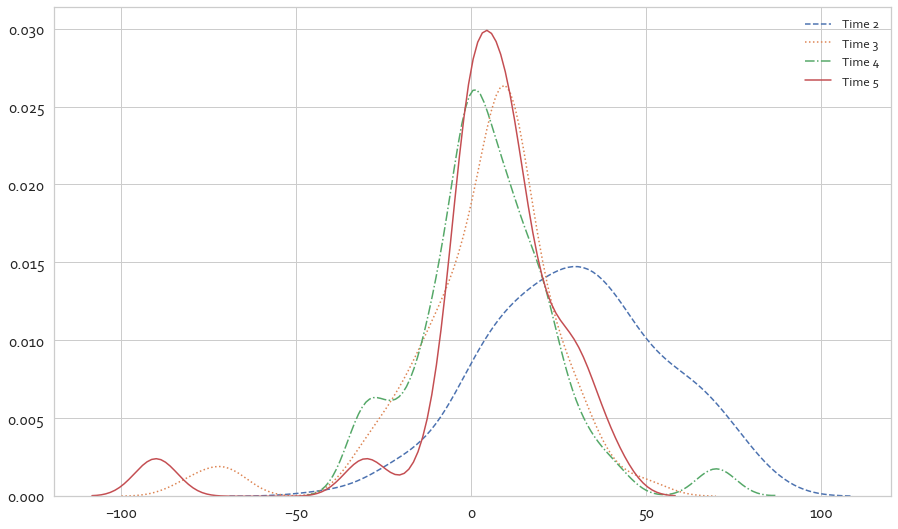

In [17]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro,levene
from pingouin import compute_effsize,compute_bootci, mwu

performance_data = pd.read_csv("D:/DPhil - University of Oxford/Reports/Study Protocol/Secondary_Summary.csv")
performance_data.loc[performance_data.Level=='StudentIntern',['Level']] = 'Student'
performance_data.loc[performance_data.Cadre=='Clinical OfficerDoctor',['Cadre']] = 'Clinical Officer'
performance_data = performance_data.groupby(['User','Session']).head(1)

performance_data.Cycle_Complete = performance_data.Cycle_Complete.astype(int)
use_lines = ['-','--',':','-.','-']
effect_df = pd.DataFrame()
sec_effect_df = pd.DataFrame()

for i in range(2,6):
    #this_cycle = performance_data[performance_data.Cycle_Complete.isin([i,i-1])]
    this_cycle = performance_data[(~(performance_data.Previous_Score.isnull())) &
        performance_data.Cycle_Complete.isin([i])]
    
    errant_users = this_cycle.groupby('User').Session.count()
    errant_users = errant_users.to_frame()
    errant_users.reset_index(inplace=True)
    errant_users.reset_index(inplace=True)
    errant_users = errant_users.User[errant_users.Session > 1].unique().tolist()
        
    this_cycle = this_cycle.groupby('User').first()
    this_cycle.reset_index(inplace=True)
    this_cycle.rename(columns={'Score':'Post','Previous_Score':'Pre'},inplace=True)
    this_cycle.Pre = this_cycle.Pre * 10
    this_cycle.Post = this_cycle.Post * 10
    
    pre_scores_ctrl = this_cycle.Pre[this_cycle.Group=='Control'].tolist()
    pre_scores_exp = this_cycle.Pre[this_cycle.Group=='Experiment'].tolist()

    post_scores_ctrl = this_cycle.Post[this_cycle.Group=='Control'].tolist()
    post_scores_exp = this_cycle.Post[this_cycle.Group=='Experiment'].tolist()
    
    ctrl_norm = [a_i - b_i for a_i, b_i in zip(post_scores_ctrl, pre_scores_ctrl)]
    exp_norm = [a_i - b_i for a_i, b_i in zip(post_scores_exp, pre_scores_exp)]
    
    ctrl_diff = np.subtract(post_scores_ctrl,pre_scores_ctrl)
    exp_diff = np.subtract(post_scores_exp,pre_scores_exp)
    
    if(i==2):
        experiment_ids = list(range(0,99))
        control_ids = list(range(0,148))
        
        boot_effect = []
        boot_pval = []
        
        for j in range(0,1000):  
            np.random.seed(j)
            choice_experiment_ids = np.random.choice(experiment_ids,83)
            choice_control_ids = np.random.choice(control_ids,83)
            
            pre_scores_ctrl_boot = [pre_scores_ctrl[index] for index in choice_control_ids]
            post_scores_ctrl_boot = [post_scores_ctrl[index] for index in choice_control_ids]

            pre_scores_exp_boot = [pre_scores_exp[index] for index in choice_experiment_ids]
            post_scores_exp_boot = [post_scores_exp[index] for index in choice_experiment_ids]
            
            x = np.subtract(post_scores_ctrl_boot,pre_scores_ctrl_boot)
            y = np.subtract(post_scores_exp_boot,pre_scores_exp_boot)

            life_effect_boot = morris_g(post_scores_ctrl_boot,
                                        pre_scores_ctrl_boot,
                                        post_scores_exp_boot,
                                        pre_scores_exp_boot)
            
            boot_effect.append(np.round(life_effect_boot[0],2))
            
            #xboot = boot_matrix(x - x.mean(), B=1) 
            #yboot = boot_matrix(y - y.mean(), B=1)
            sampling_distribution = stats.ttest_ind(x, y, equal_var=False)[1]
            boot_pval.append(sampling_distribution)
            
        boot_effect.sort()
        
        print(np.percentile(boot_effect, [2.5,97.5], axis=0))
        print(np.round(np.mean(boot_pval),3))
    
        
        
   
    print("Control Arm Correlation: %.3f " % pearsonr(pre_scores_ctrl,post_scores_ctrl)[0])        
    stat, p = shapiro(ctrl_norm)
    shapiro_ctrl = 'Control arm (Normal): < %.3f' % (p)
    print(shapiro_ctrl)
    stat, p1 = levene(pre_scores_ctrl,post_scores_ctrl)
    shapiro_pre_ctrl = 'Control arm [Pre-tests, Post-test Variance Homogenous]: %.3f' % (p1)
    print(shapiro_pre_ctrl)
    
    print("Intervention Arm Correlation: %.3f " %pearsonr(pre_scores_exp,post_scores_exp)[0])        
    stat, p = shapiro(exp_norm)
    shapiro_exp = 'Experimental arm (Normal): < %.3f' % (p)
    print(shapiro_exp)
    stat, p1 = levene(pre_scores_exp,post_scores_exp)
    shapiro_pre_exp = 'Experiment arm [Pre-tests, Post-test Variance Homogenous]: %.3f' % (p1)
    print(shapiro_pre_exp)
    
    
    stat, p = levene(ctrl_norm,exp_norm,center='median')
    levene_p = 'Homogenous Variances: < %.3f' % (p)
    print(levene_p)
            
    #d = compute_effsize(x=exp_norm, y=ctrl_norm, eftype='eta-square', paired=False)
    d = mwu(ctrl_norm,exp_norm, tail='one-sided')
    ci = non_parametric_ci(exp_norm,ctrl_norm)
    
    aov= pg.anova(dv='Gain', between='Group', data= this_cycle,detailed=True)
    
    bias_adj = bias_correct(post_scores_ctrl,post_scores_exp)
    life_effect = morris_g(post_scores_ctrl,pre_scores_ctrl,post_scores_exp,pre_scores_exp)
    
    test_summary = pd.DataFrame({
         'Cycle': i
         ,'Ctrl_Correlation': '%.3f' % pearsonr(pre_scores_ctrl,post_scores_ctrl)[0]
         ,'Ctrl_Normality Test': shapiro(ctrl_norm)[1]
         ,'Ctrl_Pre-Post Score Variance Homogenous': '%.3f' %levene(pre_scores_ctrl,post_scores_ctrl)[1]
         ,'Ctrl_N': len(post_scores_ctrl)
         ,'Correlation': '%.3f' % pearsonr(pre_scores_exp,post_scores_exp)[0]
         ,'Normality Test': shapiro(exp_norm)[1]
         ,'Pre-Post Score Variance Homogenous': '%.3f' %levene(pre_scores_exp,post_scores_exp)[1]
         ,'N': len(post_scores_exp)
         ,'Effect Size': '%.3f' % life_effect[0]
         ,'P-value': '%.3f' % d['p-val']
    }, index=[i-2])
    
    sec_effect_df = pd.concat([sec_effect_df,test_summary])
    
    print('Effect size: %.3f' % (life_effect[0])+', p-val:  %.3f' %aov['p-unc'][0])
        
    print("Sample Length: "+str(this_cycle.shape[0]))
    print("Control: "+str(len(post_scores_ctrl)))
    print("Experiment: "+str(len(post_scores_exp)))
    print()
    
    
    p_value = 1 - stats.t.cdf(life_effect[2],
                        df= ((2*len(post_scores_ctrl))+(2*len(post_scores_exp))-4))
    
    morris_ci = hedgesg_ci(life_effect[0],len(post_scores_ctrl),len(post_scores_exp),life_effect[1])
       
    plot_save = sns.distplot(ctrl_diff,hist=False,label='Time '+str(i),
                kde_kws={'linestyle':use_lines[i-1]})
    
    score = pd.DataFrame({
             'Cycle': i
             ,'Effect': life_effect[0]
             ,'P-value':morris_ci[1]
             ,'LB':morris_ci[0][0]
             ,'UB':morris_ci[0][1]
             ,'Error': life_effect[0] - morris_ci[0][0]
        }, index=[i-2])
    
    effect_df = pd.concat([effect_df,score])
    

In [ ]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro,levene
from pingouin import compute_effsize,compute_bootci, mwu

performance_data = pd.read_csv("D:/DPhil - University of Oxford/Reports/Study Protocol/Secondary_Summary.csv")
performance_data.loc[performance_data.Level=='StudentIntern',['Level']] = 'Student'
performance_data.loc[performance_data.Cadre=='Clinical OfficerDoctor',['Cadre']] = 'Clinical Officer'
performance_data = performance_data.groupby(['User','Session']).head(1)
performance_data.Session =  pd.to_datetime(performance_data.Session)
performance_data = performance_data.sort_values(["User", "Session"], ascending = (True, True))
performance_data['Time_Diff'] = performance_data.groupby('User')['Time'].apply(lambda x: x-x.shift(1))
performance_data['Try_Diff'] = performance_data.groupby('User')['Try_Count'].apply(lambda x: x-x.shift(1))
performance_data['Feedback_Diff'] = performance_data.groupby('User')['Feedback_Count'].apply(lambda x: x-x.shift(1))


performance_data = performance_data[~(performance_data.Gain.isnull())]


performance_data.Cycle_Complete = performance_data.Cycle_Complete.astype(int)
performance_data['Gain_Score'] = performance_data.Score - performance_data.Previous_Score

second_cycle_user = performance_data[performance_data.Cycle_Complete==2]
second_cycle_user['Score_Group'] = pd.qcut(second_cycle_user.Previous_Score, 3, labels=["Low","Average","High"])
second_cycle_user = second_cycle_user[['User','Score_Group']]
second_cycle_user = second_cycle_user.drop_duplicates(['User','Score_Group'])
performance_data = pd.merge(performance_data,second_cycle_user,on='User',how='left')
performance_data.Cycle_Complete = performance_data.Cycle_Complete - 1



performance_data.head()

In [ ]:
performance_test = performance_data[performance_data.Cycle_Complete==1]
performance_test[['User','Gap','Spacing','Feedback_Count','Try_Count','Time','Gain','Group']].to_csv(
    'D:\DPhil - University of Oxford\Analysis\Quantitative\MPLUS\life_play.csv',index=None)
performance_test.Group.value_counts()

In [ ]:
performance_data = pd.read_csv("D:/DPhil - University of Oxford/Reports/Study Protocol/Secondary_Summary.csv")
performance_data.loc[performance_data.Level=='StudentIntern',['Level']] = 'Student'
performance_data.loc[performance_data.Cadre=='Clinical OfficerDoctor',['Cadre']] = 'Clinical Officer'
performance_data = performance_data.groupby(['User','Session']).head(1)
performance_data.Session =  pd.to_datetime(performance_data.Session)
performance_data = performance_data.sort_values(["User", "Session"], ascending = (True, True))
performance_data['Time_Diff'] = performance_data.groupby('User')['Time'].apply(lambda x: x-x.shift(1))
performance_data['Try_Diff'] = performance_data.groupby('User')['Try_Count'].apply(lambda x: x-x.shift(1))
performance_data['Feedback_Diff'] = performance_data.groupby('User')['Feedback_Count'].apply(lambda x: x-x.shift(1))

performance_data.head()

In [25]:
performance_data_balanced = performance_data.copy()
performance_data_balanced.loc[performance_data_balanced.Cycle_Complete > 6.0, ['Cycle_Complete']] = 7.0

pd.crosstab(performance_data_balanced.Group,performance_data_balanced.Cycle_Complete,margins=True)

Cycle_Complete,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
Group,,,,,,,,
Control,242,148,75,40,27,12,17,561
Experiment,158,99,59,38,22,13,12,401
All,400,247,134,78,49,25,29,962


In [26]:
pd.crosstab(performance_data_balanced.Group,performance_data_balanced.Cycle_Complete,margins=True,normalize=True)

Cycle_Complete,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
Group,,,,,,,,
Control,0.251559,0.153846,0.077963,0.041580,0.028067,0.012474,0.017672,0.58316
Experiment,0.164241,0.102911,0.061331,0.039501,0.022869,0.013514,0.012474,0.41684
All,0.415800,0.256757,0.139293,0.081081,0.050936,0.025988,0.030146,1.00000


In [27]:
longitudinal_performance_users = performance_data[['User','Session']]
longitudinal_performance_users = longitudinal_performance_users.drop_duplicates(['User','Session'])
longitudinal_performance_users = longitudinal_performance_users.groupby('User').Session.count()
longitudinal_performance_users = longitudinal_performance_users.to_frame()
longitudinal_performance_users.reset_index(inplace=True)

In [28]:
longitudinal_performance_users = longitudinal_performance_users[longitudinal_performance_users.Session > 1]
longitudinal_performance = performance_data[performance_data.User.isin(longitudinal_performance_users.User)]
longitudinal_performance = longitudinal_performance[['User','Gain','Score','Group','Gap','Spacing','Cycle_Complete']]
longitudinal_performance = longitudinal_performance[longitudinal_performance.Cycle_Complete < 5]
longitudinal_performance.head()

,User,Gain,Score,Group,Gap,Spacing,Cycle_Complete
0,0124251270AF600B4D7B52D47E6EF095,NaN,7,Experiment,8.614201,<= 1 Week,1.0
1,0124251270AF600B4D7B52D47E6EF095,0.000000,7,Experiment,3.129646,<= 1 Hour,2.0
4,04867B312944995FFF958A2C712EC386,NaN,3,Control,2.862427,<= 1 Hour,1.0
5,04867B312944995FFF958A2C712EC386,0.142857,4,Control,1.846808,<= 1 Hour,2.0
6,04867B312944995FFF958A2C712EC386,0.833333,9,Control,0.844301,<= 1 Hour,3.0


In [29]:
print('n: %.4f' % pg.power_rm_anova(eta=0.1, m=3, power=0.80))

n: 15.9979


In [30]:
performance_data.to_csv('D:\DPhil - University of Oxford\Reports\Study Protocol\long_gain.csv',index=False)
performance_data.to_stata('D:\DPhil - University of Oxford\Reports\Study Protocol\long_gain.dta')

In [93]:
performance_data = performance_data[~(performance_data.Gain.isnull()) & (performance_data.Cycle_Complete < 7)
                                   ]
#performance_data.to_csv('D:/DPhil - University of Oxford/Reports/Study Protocol/repeated_measures.csv',index=False)

def test_normality(x):
    return '%.3f' % shapiro(x)[1]

#performance_data.groupby('Cycle_Complete').Gain.apply(test_normality)

In [94]:
performance_data.head()

,User,Session,Cycle_Complete,Score,Previous_Score,Gain,Time,Feedback_Count,Try_Count,SRL,...,Spacing,Cadre,Level,Age,Experience,Group,ETAT,Time_Diff,Try_Diff,Feedback_Diff
1,0124251270AF600B4D7B52D47E6EF095,2019-06-05 22:54:18,2.0,7,7.0,0.000000,757.146,10.0,17,NaN,...,<= 1 Hour,NaN,NaN,NaN,NaN,Experiment,No,416.859,2.0,-4.0
5,04867B312944995FFF958A2C712EC386,2019-04-09 18:53:53,2.0,4,3.0,0.142857,287.836,10.0,20,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,-700.152,-27.0,-27.0
6,04867B312944995FFF958A2C712EC386,2019-04-09 19:04:45,3.0,9,4.0,0.833333,225.576,1.0,11,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,-62.260,-9.0,-9.0
7,04867B312944995FFF958A2C712EC386,2019-04-09 19:21:38,4.0,10,9.0,1.000000,110.178,0.0,10,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,-115.398,-1.0,-1.0
8,04867B312944995FFF958A2C712EC386,2019-04-09 19:56:44,5.0,10,10.0,0.000000,232.348,0.0,10,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,122.170,0.0,0.0


In [32]:
norm_plot = performance_data.copy()
norm_plot = norm_plot[['User','Cycle_Complete','Gain','Spacing','Group']]
norm_plot.loc[norm_plot.Spacing=='> 1 Month',['Spacing']]= '<= 1 Month' 
norm_plot = norm_plot.drop_duplicates(['User','Cycle_Complete','Gain','Spacing','Group'])
norm_plot.Spacing = pd.Categorical(norm_plot["Spacing"].tolist(), 
                                                   categories=["<= 1 Hour", "<= 1 Day", "<= 1 Week", '<= 1 Month' ],
                                                   ordered=False)
norm_plot = norm_plot[norm_plot.Cycle_Complete < 7]
norm_plot.head()

,User,Cycle_Complete,Gain,Spacing,Group
1,0124251270AF600B4D7B52D47E6EF095,2.0,0.000000,<= 1 Hour,Experiment
5,04867B312944995FFF958A2C712EC386,2.0,0.142857,<= 1 Hour,Control
6,04867B312944995FFF958A2C712EC386,3.0,0.833333,<= 1 Hour,Control
7,04867B312944995FFF958A2C712EC386,4.0,1.000000,<= 1 Hour,Control
8,04867B312944995FFF958A2C712EC386,5.0,0.000000,<= 1 Hour,Control


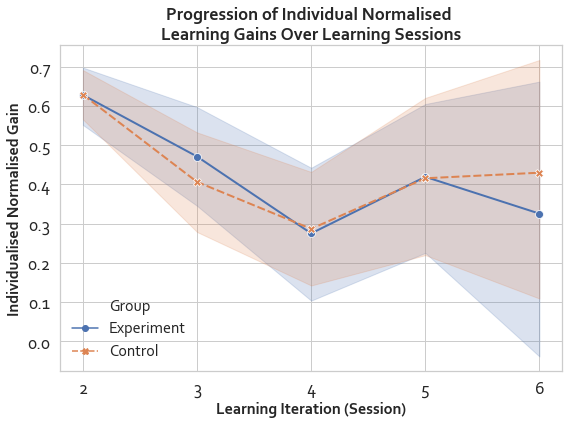

In [57]:
sns.set(rc={'figure.figsize':(9,6),'lines.linewidth': 5, 'lines.markersize': 10})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

fig, ax = plt.subplots(figsize=(9, 6))

g = sns.lineplot(x="Cycle_Complete",
                 y="Gain",
                 hue="Group",
                 markers=True,
                 palette=["C0","C1"],
                 style="Group",
                 data=norm_plot,
                 legend="full",
                 markersize=8,
                 linewidth=2)

fig.get_axes()[0].legend(loc='lower left')
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16', weight='bold') # for legend title
ax.set_xticks(np.arange(2, 7, step=1))  
ax.set_xlabel('Learning Iteration (Session)',weight='bold').set_fontsize('16')
ax.set_ylabel('Individualised Normalised Gain',weight='bold').set_fontsize('16')
ax.set_title("Progression of Individual Normalised \nLearning Gains Over Learning Sessions",weight='bold').set_fontsize('18')

In [61]:
from PIL import Image
from io import BytesIO

#png_image = BytesIO()
#fig.savefig(png_image, format='png',dpi=1200,bbox_inches='tight',pad_inches=0)
fig.savefig('D:/DPhil - University of Oxford/Reports/Study Protocol/Supplementary Figure 4.png',
           dpi=1200,bbox_inches='tight',pad_inches=0)

#png_memory = Image.open(png_image)
#png_memory.save('D:/DPhil - University of Oxford/Reports/Study Protocol/Supplementary Figure 4.tiff',
#                compression='lzw',dpi=[1200,1200])
#png_image.close()

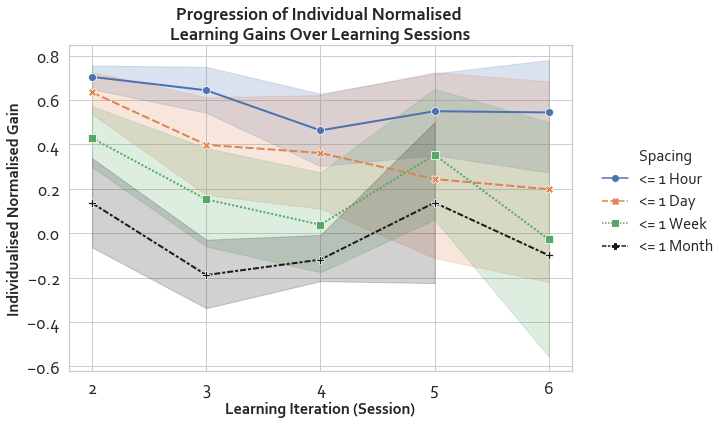

In [63]:
fig, ax = plt.subplots(figsize=(9, 6))

g = sns.lineplot(x="Cycle_Complete",
                 y="Gain",
                 hue="Spacing",
                 markers=True,
                 palette=["C0","C1","C2","k"],
                 style="Spacing",
                 data=norm_plot,
                 legend="full",
                 markersize=8,
                 linewidth=2)

handles, labels = ax.get_legend_handles_labels()
#plt.legend(handles=handles[1:], labels=labels[1:],fontsize=16,ncol=2, bbox_to_anchor=(.95, -0.25))
#ax.legend(handles=handles[1:], labels=labels[1:], title="Session Spacing")
plt.legend(bbox_to_anchor=(1.05, .7), loc=2, borderaxespad=0.)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16', weight='bold') # for legend title
#ax.legend(handles=handles[1:], labels=labels[1:], title=)


ax.set_xticks(np.arange(2, 7, step=1))  
ax.set_xlabel('Learning Iteration (Session)',weight='bold').set_fontsize('16')
ax.set_ylabel('Individualised Normalised Gain',weight='bold').set_fontsize('16')
ax.set_title("Progression of Individual Normalised \nLearning Gains Over Learning Sessions",weight='bold').set_fontsize('18')

In [64]:
fig.savefig('D:/DPhil - University of Oxford/Reports/Study Protocol/Supplementary Figure 6.png', 
            dpi=1200,bbox_inches='tight',pad_inches=0)

#png_memory = Image.open(png_image)
#png_memory.save('D:/DPhil - University of Oxford/Reports/Study Protocol/Supplementary Figure 5.tiff',
#                compression='tiff_lzw',dpi=[1200,1200])
#png_image.close()

In [ ]:
performance_data.Level.value_counts()

In [ ]:
#png_image = BytesIO()
#plot_save.figure.savefig(png_image, format='png',dpi=600,bbox_inches='tight',pad_inches=0)

#png_memory = Image.open(png_image)
#png_memory.save('D:/DPhil - University of Oxford/Reports/Study Protocol/Figure 2.tiff',compression='tiff_lzw',dpi=[1200,1200])
#png_image.close()

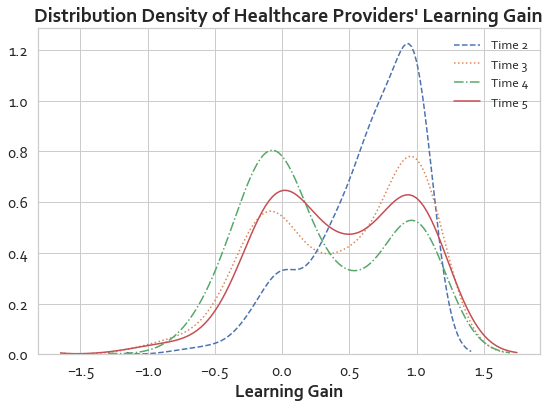

In [95]:
for i in range(2,6):
    #this_cycle = performance_data[performance_data.Cycle_Complete.isin([i,i-1])]
    this_cycle = performance_data[(~(performance_data.Previous_Score.isnull())) &
        performance_data.Cycle_Complete.isin([i])]    
          
    this_cycle = this_cycle.groupby('User').first()
    this_cycle.reset_index(inplace=True)
    this_cycle.rename(columns={'Score':'Post','Previous_Score':'Pre'},inplace=True)
    this_cycle.Pre = this_cycle.Pre * 10
    this_cycle.Post = this_cycle.Post * 10
      
    ax = sns.distplot(this_cycle.Gain,hist=False,label='Time '+str(i),kde_kws={'linestyle':use_lines[i-1]})
    ax.set_xlabel('Learning Gain',weight='bold').set_fontsize('18')
    ax.set_title("Distribution Density of Healthcare Providers' Learning Gain",weight='bold').set_fontsize('20')

In [25]:
png_image = BytesIO()
ax.figure.savefig(png_image, format='png',dpi=600,bbox_inches='tight',pad_inches=0)

png_memory = Image.open(png_image)
png_memory.save('D:/DPhil - University of Oxford/Reports/Study Protocol/Figure 3.tiff',compression='tiff_lzw',dpi=[1200,1200])
png_image.close()

In [96]:
def linearity_test(model, x_pred ,y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict(x_pred)
    resids = model.resid
        
    fig, ax = plt.subplots(1,2,figsize=(9, 6))
    
    sns.regplot(x=fitted_vals, y=np.squeeze(y), lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
def homoscedasticity_test(model, x_pred):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict(x_pred)
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2,figsize=(9, 6))

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

In [97]:
performance_data.head()

,User,Session,Cycle_Complete,Score,Previous_Score,Gain,Time,Feedback_Count,Try_Count,SRL,...,Spacing,Cadre,Level,Age,Experience,Group,ETAT,Time_Diff,Try_Diff,Feedback_Diff
1,0124251270AF600B4D7B52D47E6EF095,2019-06-05 22:54:18,2.0,7,7.0,0.000000,757.146,10.0,17,NaN,...,<= 1 Hour,NaN,NaN,NaN,NaN,Experiment,No,416.859,2.0,-4.0
5,04867B312944995FFF958A2C712EC386,2019-04-09 18:53:53,2.0,4,3.0,0.142857,287.836,10.0,20,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,-700.152,-27.0,-27.0
6,04867B312944995FFF958A2C712EC386,2019-04-09 19:04:45,3.0,9,4.0,0.833333,225.576,1.0,11,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,-62.260,-9.0,-9.0
7,04867B312944995FFF958A2C712EC386,2019-04-09 19:21:38,4.0,10,9.0,1.000000,110.178,0.0,10,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,-115.398,-1.0,-1.0
8,04867B312944995FFF958A2C712EC386,2019-04-09 19:56:44,5.0,10,10.0,0.000000,232.348,0.0,10,High SRL profile,...,<= 1 Hour,Clinical Officer,Intern,24.0,3.0,Control,Yes,122.170,0.0,0.0


In [98]:
performance_data = performance_data.groupby(['User','Session']).first()
performance_data.reset_index(inplace=True)
performance_data_nodem = performance_data[~(performance_data.Previous_Score.isnull())]
performance_data_nodem.loc[performance_data_nodem.Spacing == '> 1 Month',['Spacing']] = '<= 1 Month'
performance_data_nodem = performance_data_nodem[performance_data_nodem.Cycle_Complete == 2]
performance_data_nodem["Help_Ratio"] = np.divide(performance_data_nodem["Feedback_Count"],performance_data_nodem["Try_Count"])

std_scaler = preprocessing.StandardScaler()
performance_data_nodem.Time = std_scaler.fit_transform(performance_data_nodem.Time.values.reshape(-1,1))
performance_data_nodem.Help_Ratio = std_scaler.fit_transform(performance_data_nodem.Help_Ratio.values.reshape(-1,1))
performance_data_nodem.Previous_Score = std_scaler.fit_transform(performance_data_nodem.Previous_Score.values.reshape(-1,1))
performance_data_nodem.head()

,User,Session,Cycle_Complete,Score,Previous_Score,Gain,Time,Feedback_Count,Try_Count,SRL,...,Cadre,Level,Age,Experience,Group,ETAT,Time_Diff,Try_Diff,Feedback_Diff,Help_Ratio
0,0124251270AF600B4D7B52D47E6EF095,2019-06-05 22:54:18,2.0,7,0.717517,0.000000,5.685311,10.0,17,NaN,...,NaN,NaN,NaN,NaN,Experiment,No,416.859,2.0,-4.0,0.555514
1,04867B312944995FFF958A2C712EC386,2019-04-09 18:53:53,2.0,4,-1.054750,0.142857,1.163176,10.0,20,High SRL profile,...,Clinical Officer,Intern,24.0,3.0,Control,Yes,-700.152,-27.0,-27.0,0.296173
6,05656BA6C69B8C4E67E4DE84C8244CBF,2019-07-08 07:27:53,2.0,10,-1.054750,1.000000,-0.061725,0.0,10,Average SRL profile,...,Doctor,Student,31.0,4.0,Control,Yes,-214.044,-10.0,-10.0,-1.173422
7,06C33DDBD8B7ED6575306DAA76FBAD37,2019-03-02 02:06:08,2.0,9,-0.168616,0.800000,-0.529173,7.0,11,NaN,...,NaN,NaN,NaN,NaN,Experiment,No,-251.604,-5.0,-9.0,0.696972
9,0AB946318D9783478074F87185088450,2019-03-15 17:20:37,2.0,7,0.274450,0.250000,0.065292,10.0,13,High SRL profile,...,Nurse,Specialised,34.0,9.0,Experiment,Yes,-249.846,-5.0,-8.0,1.087494


In [44]:
performance_data_nodem.shape

(247, 19)

In [99]:
performance_data_nodem.rename(columns={'Score':'Post',
                                       'Previous_Score':'Pre',
                                       'Feedback_Diff':'Hints',
                                       'Try_Diff':'Tries'},inplace=True)

performance_data_nodem["Spacing"] = pd.Categorical(performance_data_nodem["Spacing"].tolist(), 
                                                   categories=["<= 1 Hour", "<= 1 Day", "<= 1 Week", '<= 1 Month' ],
                                                   ordered=False)
performance_data_nodem["ETAT"] = pd.Categorical(performance_data_nodem["ETAT"].tolist(), 
                                                   categories=["No", "Yes" ],
                                                   ordered=True)

performance_data_nodem["Group"] = pd.Categorical(performance_data_nodem["Group"].tolist(), 
                                                   categories=["Control", "Experiment" ],
                                                   ordered=True)

performance_data_nodem = sm.add_constant(performance_data_nodem)
x_pred = performance_data_nodem[['Time_Diff','Spacing','Group','Tries','Hints','ETAT','Cycle_Complete','Pre']]
y = performance_data_nodem[['Gain']]
model = smf.ols('Gain ~ Time_Diff + Spacing + Group + Hints + Tries + ETAT + Pre*Group',
                data = performance_data_nodem).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gain   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     11.78
Date:                Thu, 12 Mar 2020   Prob (F-statistic):           2.03e-16
Time:                        21:33:09   Log-Likelihood:                -64.176
No. Observations:                 247   AIC:                             150.4
Df Residuals:                     236   BIC:                             189.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4722      0.052      9.130      0.000       0.370       0.574
Spacing[T.<= 1 Day]        -0.0894      0.054     -1.665      0.097      -0.195       0.016
Spacing[T.<= 1 Week]       -0.2130      0.078     -2.713      0.007      -0.368      -0.058
Spacing[T.<= 1 Month]      -0.4311      0.082     -5.264      0.000      -0.592      -0.270
Group[T.Experiment]         0.0425      0.056      0.761      0.447      -0.067       0.153
ETAT[T.Yes]                 0.0017      0.043      0.040      0.968      -0.082       0.086
Time_Diff                  -0.0003      0.000     -1.551      0.122      -0.001    7.07e-05
Hints                       0.0081      0.015      0.535      0.593      -0.022       0.038
Tries                      -0.0344      0.016     -2.179      0.030      -0.065      -0.003
Pre                         0.0201      0.033      0.602      0.548      -0.046       0.086
Pre:Group[T.Experiment]     0.0713      0.046      1.555      0.121      -0.019       0.162
==============================================================================
Omnibus:                       39.331   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.752
Skew:                          -0.956   Prob(JB):                     2.88e-13
Kurtosis:                       4.399   Cond. No.                         958.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
ols_std_data = x_pred.copy()

In [102]:
x_pred_const = x_pred[['Time_Diff', 'Tries', 'Hints']]

vif = [variance_inflation_factor(x_pred_const.values, i) for i in range(x_pred_const.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=x_pred_const.columns).T

,Time_Diff,Tries,Hints
vif,2.823869,22.851905,23.587785


In [83]:
x_pred['Prediction'] = model.predict(x_pred)
x_pred['Pre_Perc'] = x_pred.Pre * 10
x_pred.head()

,Time,Spacing,Group,Help_Ratio,ETAT,Cycle_Complete,Pre,Prediction,Pre_Perc
1,5.685311,<= 1 Hour,Experiment,0.588235,No,2.0,7.0,0.179778,70.0
5,1.163176,<= 1 Hour,Control,0.500000,Yes,2.0,3.0,0.278296,30.0
13,-0.061725,<= 1 Hour,Control,0.000000,Yes,2.0,3.0,1.063178,30.0
15,-0.529173,<= 1 Hour,Experiment,0.636364,No,2.0,5.0,0.873493,50.0
18,0.065292,<= 1 Hour,Experiment,0.769231,Yes,2.0,6.0,0.568186,60.0


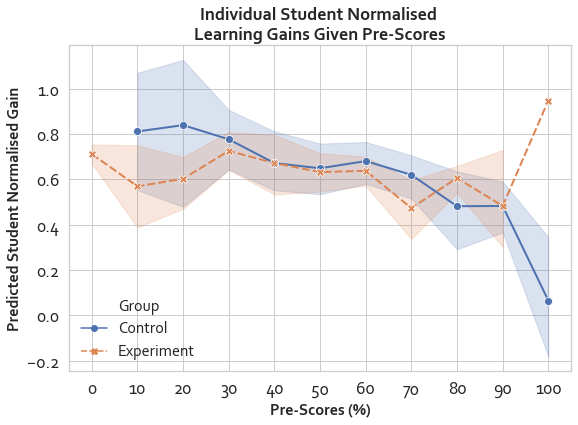

In [85]:
sns.set(rc={'figure.figsize':(9,6),'lines.linewidth': 5, 'lines.markersize': 10})
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid",{"font.family": ["Corbel"]})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

fig, ax = plt.subplots(figsize=(9, 6))

g = sns.lineplot(x="Pre_Perc",
                 y="Prediction",
                 hue="Group",
                 markers=True,
                 palette=["C0","C1"],
                 style="Group",
                 data=x_pred,
                 legend="full",
                 markersize=8,
                 linewidth=2)

fig.get_axes()[0].legend(loc='lower left')
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16', weight='bold') # for legend title
ax.set_xticks(np.arange(0, 101, step=10))  
ax.set_xlabel('Pre-Scores (%)',weight='bold').set_fontsize('16')
ax.set_ylabel('Predicted Student Normalised Gain',weight='bold').set_fontsize('16')
ax.set_title("Individual Student Normalised \nLearning Gains Given Pre-Scores",weight='bold').set_fontsize('18')

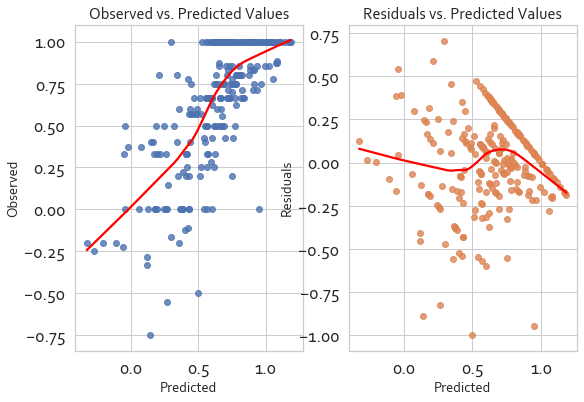

In [59]:
linearity_test(model, x_pred, y) 


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  5.519989e+01
p-value                        1.115652e-08
f-value                        7.578709e+00
f p-value                      9.361667e-10

 Goldfeld-Quandt test ----
                value
F statistic  1.192376
p-value      0.174903

 Residuals plots ----


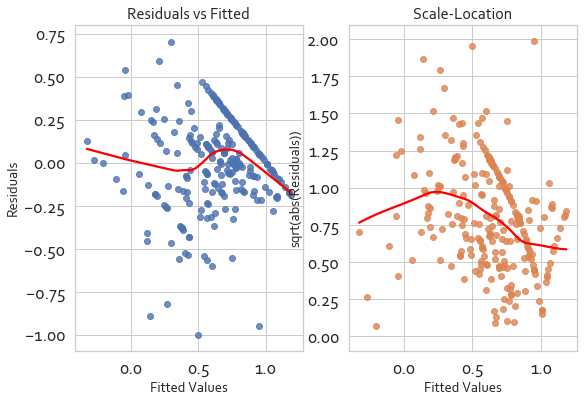

In [60]:
homoscedasticity_test(model,x_pred)

In [61]:
performance_data_dem = performance_data_nodem[~(performance_data_nodem.Cadre.isnull())] 

performance_data_dem["Level"] = pd.Categorical(performance_data_dem["Level"].tolist(),
                                               categories=["Student", "Intern", "General Officer", 'Specialised' ],
                                               ordered=False)

performance_data_dem["Cadre"] = pd.Categorical(performance_data_dem["Cadre"].tolist(),
                                               categories=["Nurse","Clinical Officer",'Doctor','Other'],
                                               ordered=False)


performance_data_dem.Age = std_scaler.fit_transform(performance_data_dem.Age.values.reshape(-1,1))
performance_data_dem.Experience = std_scaler.fit_transform(performance_data_dem.Experience.values.reshape(-1,1))

In [62]:
performance_data_dem.Group.value_counts()

Control       84
Experiment    51
Name: Group, dtype: int64

In [63]:
performance_data_dem.head()

,User,Session,Cycle_Complete,Post,Pre,Gain,Time,Hints,Tries,SRL,Gap,Spacing,Cadre,Level,Age,Experience,Group,ETAT,Help_Ratio
5,04867B312944995FFF958A2C712EC386,2019-04-09 18:53:53,2.0,4,3.0,0.142857,1.163176,10.0,20,High SRL profile,1.846808,<= 1 Hour,Clinical Officer,Intern,-0.159257,-0.486962,Control,Yes,0.500000
13,05656BA6C69B8C4E67E4DE84C8244CBF,2019-07-08 07:27:53,2.0,10,3.0,1.000000,-0.061725,0.0,10,Average SRL profile,3.290737,<= 1 Hour,Doctor,Student,-0.143959,-0.348853,Control,Yes,0.000000
18,0AB946318D9783478074F87185088450,2019-03-15 17:20:37,2.0,7,6.0,0.250000,0.065292,10.0,13,High SRL profile,3.658310,<= 1 Hour,Nurse,Specialised,-0.137403,0.341692,Experiment,Yes,0.769231
21,0ADC010CB2A7ED42CC6424BAC49696BB,2019-04-02 13:34:48,2.0,5,7.0,-0.285714,1.140069,18.0,20,Above Average SRL profile,7.318625,<= 1 Week,Nurse,Student,-0.163628,-0.486962,Experiment,Yes,0.900000
25,0B0AA25AA72B861F6C14C8D653827390,2019-04-17 20:06:25,2.0,10,7.0,1.000000,-0.653262,0.0,10,Above Average SRL profile,1.879185,<= 1 Hour,Doctor,General Officer,-0.143959,-0.210744,Control,No,0.000000


In [75]:
model = smf.ols('Gain ~ Time+Spacing+Group+Help_Ratio+ETAT+Pre*Group+ Cadre + Level + Age + Experience',
                data = performance_data_dem).fit()
x_pred = performance_data_dem[['Time','Spacing','Group','Help_Ratio','ETAT','Cycle_Complete',
                               'Cadre','Level','Age','Experience','Pre']]
y = performance_data_dem[['Gain']]
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gain   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     12.19
Date:                Wed, 19 Feb 2020   Prob (F-statistic):           1.03e-18
Time:                        12:27:25   Log-Likelihood:                 4.3718
No. Observations:                 135   AIC:                             27.26
Df Residuals:                     117   BIC:                             79.55
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.2786      0.100     12.845      0.000       1.081       1.476
Spacing[T.<= 1 Day]          -0.0176      0.060     -0.293      0.770      -0.137       0.102
Spacing[T.<= 1 Week]         -0.1396      0.083     -1.677      0.096      -0.305       0.025
Spacing[T.<= 1 Month]        -0.3149      0.109     -2.894      0.005      -0.530      -0.099
Group[T.Experiment]           0.9582      0.201      4.761      0.000       0.560       1.357
ETAT[T.Yes]                  -0.0280      0.048     -0.584      0.561      -0.123       0.067
Cadre[T.Clinical Officer]    -0.0037      0.071     -0.052      0.958      -0.144       0.137
Cadre[T.Doctor]               0.0946      0.053      1.790      0.076      -0.010       0.199
Cadre[T.Other]                0.0037      0.091      0.040      0.968      -0.177       0.184
Level[T.Intern]              -0.0367      0.080     -0.456      0.650      -0.196       0.123
Level[T.General Officer]      0.0512      0.059      0.862      0.391      -0.066       0.169
Level[T.Specialised]          0.0213      0.073      0.294      0.769      -0.123       0.165
Time                         -0.0702      0.032     -2.208      0.029      -0.133      -0.007
Help_Ratio                   -1.4808      0.195     -7.585      0.000      -1.867      -1.094
Pre                          -0.0790      0.014     -5.801      0.000      -0.106      -0.052
Pre:Group[T.Experiment]      -0.0241      0.024     -1.020      0.310      -0.071       0.023
Age                          -0.0126      0.023     -0.549      0.584      -0.058       0.033
Experience                   -0.0335      0.026     -1.281      0.203      -0.085       0.018
==============================================================================
Omnibus:                       13.801   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.023
Skew:                          -0.566   Prob(JB):                     7.40e-05
Kurtosis:                       4.449   Cond. No.                         77.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
from statsmodels.compat import lzip

name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(model.resid)
lzip(name, test)

[('Chi^2', 38.150512718106164),
 ('Two-tail probability', 5.196625527374993e-09)]

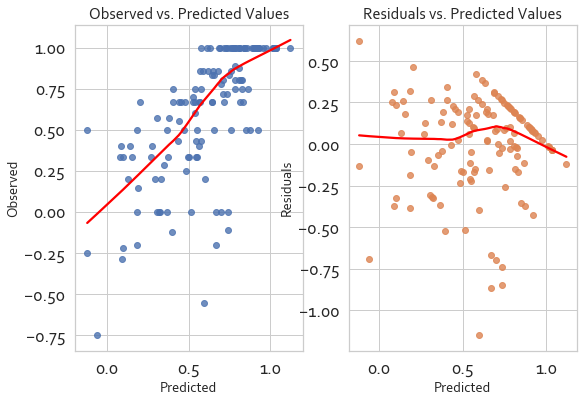

In [73]:
linearity_test(model, x_pred, y) 


 Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  13.177367
p-value                         0.588600
f-value                         0.858136
f p-value                       0.611823

 Goldfeld-Quandt test ----
                value
F statistic  0.816286
p-value      0.765173

 Residuals plots ----


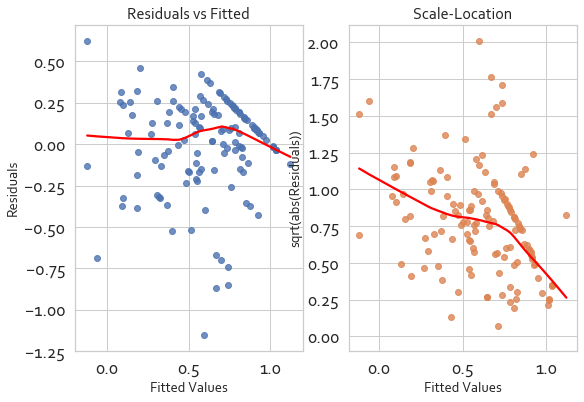

In [74]:
homoscedasticity_test(model,x_pred)

In [117]:
x_pred_const = x_pred[['Time', 'Help_Ratio', 'Age','Experience']]

vif = [variance_inflation_factor(x_pred_const.values, i) for i in range(x_pred_const.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=x_pred_const.columns).T

,Time,Help_Ratio,Age,Experience
vif,1.041328,1.018684,1.025009,1.046533


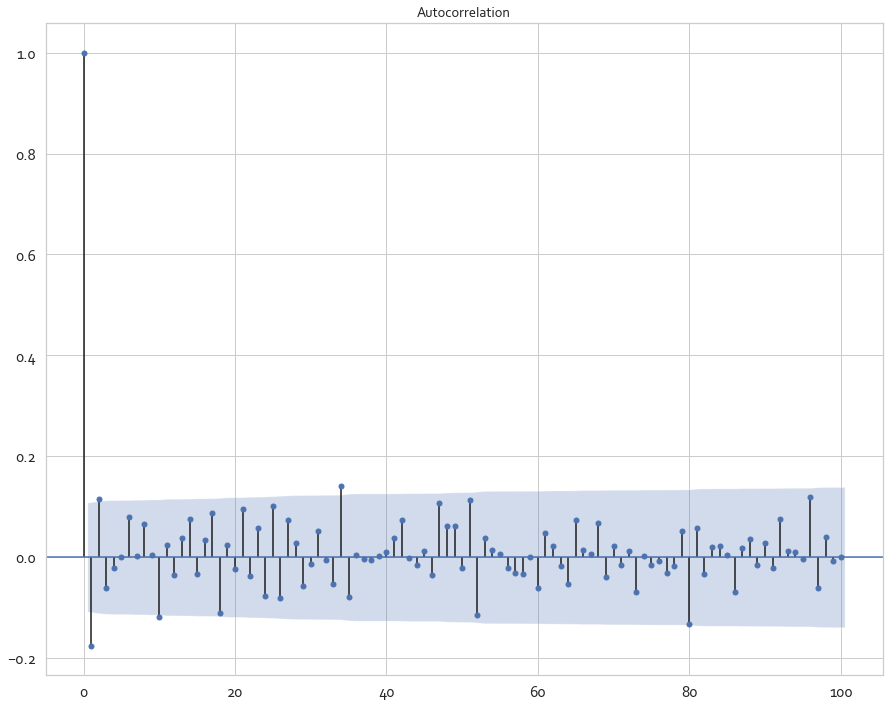

In [47]:
acf = smt.graphics.plot_acf(model.resid, lags=100 , alpha=0.05)
acf.show()

In [46]:
performance_data_mlm = performance_data[~(performance_data.Previous_Score.isnull())]
performance_data_mlm.loc[performance_data_mlm.Cadre=='Clinical OfficerDoctor',['Cadre']] = 'Clinical Officer'
performance_data_mlm.rename(columns={'Score':'Post','Previous_Score':'Pre',
                                       'Feedback_Count':'Hints','Try_Count':'Tries'},inplace=True)

performance_data_mlm = performance_data_mlm[~(performance_data_mlm.Cadre.isnull())]
performance_data_mlm.loc[performance_data_mlm.Spacing == '> 1 Month',['Spacing']] = '<= 1 Month'

performance_data_mlm["Spacing"] = performance_data_mlm["Spacing"].astype('category')
performance_data_mlm["Group"] = performance_data_mlm["Group"].astype('category')
performance_data_mlm["Level"] = performance_data_mlm["Level"].astype('category')
performance_data_mlm["Cadre"] = performance_data_mlm["Cadre"].astype('category')

performance_data_mlm.Time = std_scaler.fit_transform(performance_data_mlm.Time.values.reshape(-1,1))
performance_data_mlm.Age = std_scaler.fit_transform(performance_data_mlm.Age.values.reshape(-1,1))
performance_data_mlm.Experience = std_scaler.fit_transform(performance_data_mlm.Experience.values.reshape(-1,1))

performance_data_mlm["Help_Ratio"] = np.divide(performance_data_mlm["Hints"],performance_data_mlm["Tries"])
performance_data_mlm.to_stata('D:/DPhil - University of Oxford/Reports/Study Protocol/LIFE_mlm.dta')
performance_data_mlm.head()

,User,Session,Cycle_Complete,Post,Pre,Gain,Time,Hints,Tries,SRL,Spacing,Cadre,Level,Age,Experience,Group,ETAT,Help_Ratio
5,04867B312944995FFF958A2C712EC386,2019-04-09 18:53:53,2,4,3.0,0.142857,1.283722,10.0,20,High SRL profile,<= 1 Hour,Clinical Officer,Intern,-0.208504,-0.519139,Control,Yes,0.500000
6,04867B312944995FFF958A2C712EC386,2019-04-09 19:04:45,3,9,4.0,0.833333,0.654412,1.0,11,High SRL profile,<= 1 Hour,Clinical Officer,Intern,-0.208504,-0.519139,Control,Yes,0.090909
7,04867B312944995FFF958A2C712EC386,2019-04-09 19:21:38,4,10,9.0,1.000000,-0.512006,0.0,10,High SRL profile,<= 1 Hour,Clinical Officer,Intern,-0.208504,-0.519139,Control,Yes,0.000000
8,04867B312944995FFF958A2C712EC386,2019-04-09 19:56:44,5,10,10.0,0.000000,0.722862,0.0,10,High SRL profile,<= 1 Hour,Clinical Officer,Intern,-0.208504,-0.519139,Control,Yes,0.000000
9,04867B312944995FFF958A2C712EC386,2019-04-09 22:38:25,6,9,10.0,-0.100000,-0.529290,1.0,11,High SRL profile,<= 1 Day,Clinical Officer,Intern,-0.208504,-0.519139,Control,Yes,0.090909


In [51]:
x_ctrl=['Pre-test']*len(combine_features.Pre[combine_features.StudyGroup==1])
x_ctrl.extend(['Post-test']*len(combine_features.Post[combine_features.StudyGroup==1]))

y_ctrl=combine_features.Pre[combine_features.StudyGroup==1].tolist()
y_ctrl.extend(combine_features.Post[combine_features.StudyGroup==1].tolist())
y_ctrl = np.round(y_ctrl,2)

x_exp=['Pre-test']*len(combine_features.Pre[combine_features.StudyGroup==2])
x_exp.extend(['Post-test']*len(combine_features.Post[combine_features.StudyGroup==2]))

y_exp=combine_features.Pre[combine_features.StudyGroup==2].tolist()
y_exp.extend(combine_features.Post[combine_features.StudyGroup==2].tolist())
y_exp = np.round(y_exp,2)

control_group = go.Box(
    y=y_ctrl,
    x=x_ctrl,
    name = 'Control Group',
)
experiment_group = go.Box(
    y=y_exp,
    x=x_exp,
    name = 'Experiment Group',
)

layout = go.Layout(
    title='Differences in test scores',
    xaxis=dict(title='Study Groups'),
    yaxis=dict(title='Score (%)'),
    boxmode='group',
    font=dict(family='Corbel', size=18, color='#7f7f7f')
)

data = [control_group,experiment_group]
py.iplot(go.Figure(data=data,layout=layout))